In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss
import fastai.callbacks.hooks
import json
from fastai.vision.gan import basic_generator

In [3]:
path = untar_data(URLs.CIFAR)

In [4]:
noise = TfmPixel(lambda x: F.dropout(x,0.1))

In [43]:
# src = (ImageImageList.from_csv(path,"train_v2.csv",folder="train-jpg",suffix=".jpg")
#                      .random_split_by_pct(0.2)
#                      .label_from_func(lambda x: x))
src = (ImageImageList.from_folder(path).filter_by_rand(p=0.05).random_split_by_pct(0.2).label_from_func(lambda x: x))
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
# tfms[0].append(noise())
dataAE = src.transform(size=64,tfm_y=True).databunch(bs=16,num_workers=0).normalize(imagenet_stats,do_y=True)
#dataAE.train_ds.tfms = [noise(),noise()]
#dataAE.valid_ds.tfms = [noise(),noise()]

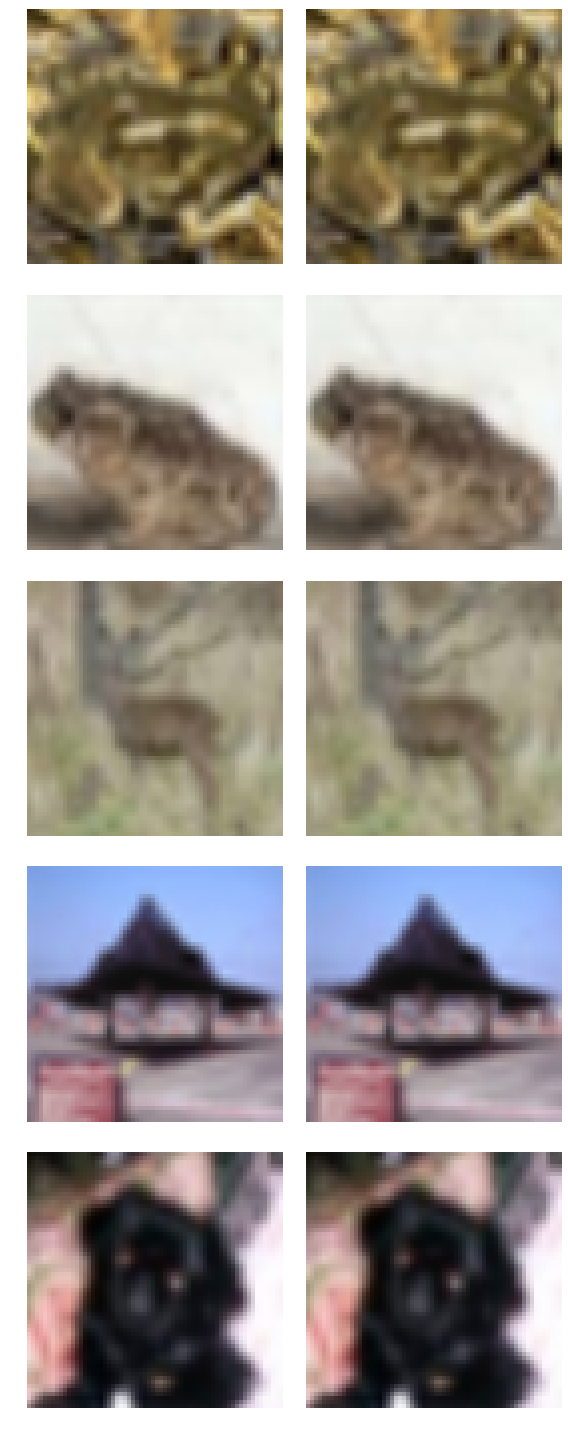

In [44]:
dataAE.show_batch()

In [104]:
#(h-7)//4 + 1
#(h-1)//2
#(h-1)//2
#(h-1)//2
class Decoder(nn.Module):
    def __init__(self,nf=256):
        super().__init__()
        self.layers = []
        self.layers.append(nn.ConvTranspose2d(nf,384,3,stride=2))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(384,192,3,stride=2))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(192,64,3,stride=2))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(64,32,3,stride=2))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.ConvTranspose2d(32,16,4,stride=2))
        self.layers.append(nn.ReLU())
        self.layers.append(conv2d(16,3))
        self.layers = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.layers(x)

In [105]:
class ImageAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.hero = create_body(models.alexnet,pretrained=False)
        #self.hero = SidekickAlexnetBase()
        self.decoder = Decoder()
        
    def forward(self,x):
        x = self.hero(x)
        return self.decoder(x)

In [106]:
class ShowImage(LearnerCallback):
    def on_epoch_end(self,pbar,epoch,last_output,last_target,**kwargs):
        if not hasattr(self,"images"):
            self.images = [dataAE.train_ds.y.reconstruct(last_target[0])]
            self.titles = ["Target"]
        img = dataAE.train_ds.y.reconstruct(dataAE.denorm(last_output[0]))
        self.images.append(img)
        self.titles.append(f"Epoch {epoch}")
        pbar.show_imgs(self.images,self.titles)

In [107]:
learn = Learner(dataAE,ImageAE(),loss_func=MSELossFlat(),callback_fns=[ShowImage])
learn.split([learn.model.hero,learn.model.decoder])
#learn.split([learn.model.hero.hero,learn.model.hero.features[0],learn.model.decoder])

In [108]:
learn.model(next(iter(dataAE.train_dl))[0]).shape

torch.Size([16, 3, 64, 64])

In [109]:
learn.freeze_to(1)

In [ ]:
learn.fit_one_cycle(20,1e-2)

epoch,train_loss,valid_loss


epoch,train_loss,valid_loss
1,0.456318,0.443622
2,0.424442,0.423176
3,0.414757,0.406543
4,0.412967,0.388989
5,0.401544,0.396006
6,0.396627,0.398434
7,0.393901,0.392348
8,0.397242,0.406556
9,0.381088,0.363036
10,0.372967,0.372633


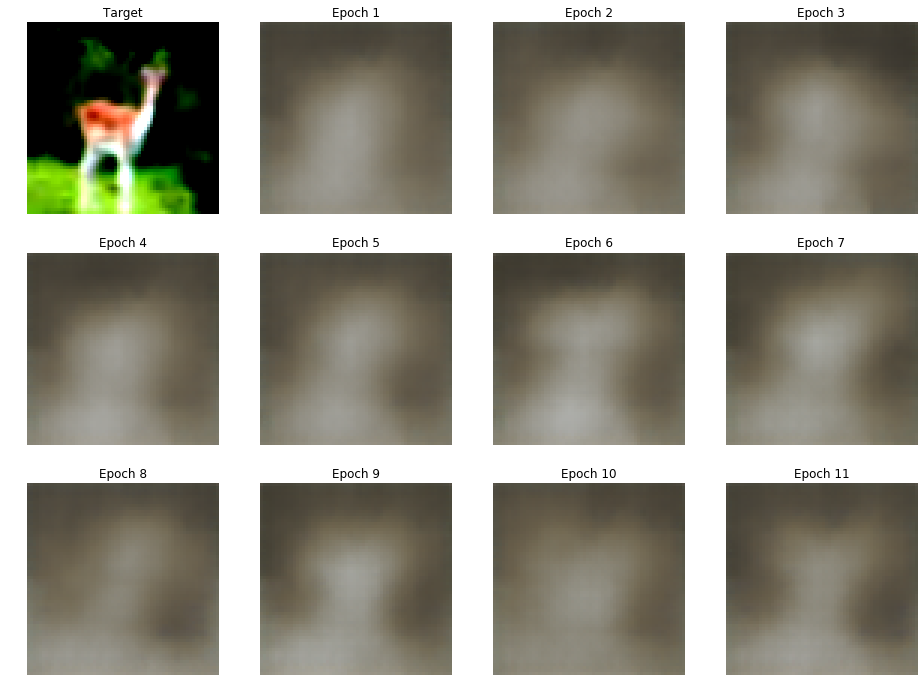

KeyboardInterrupt: 

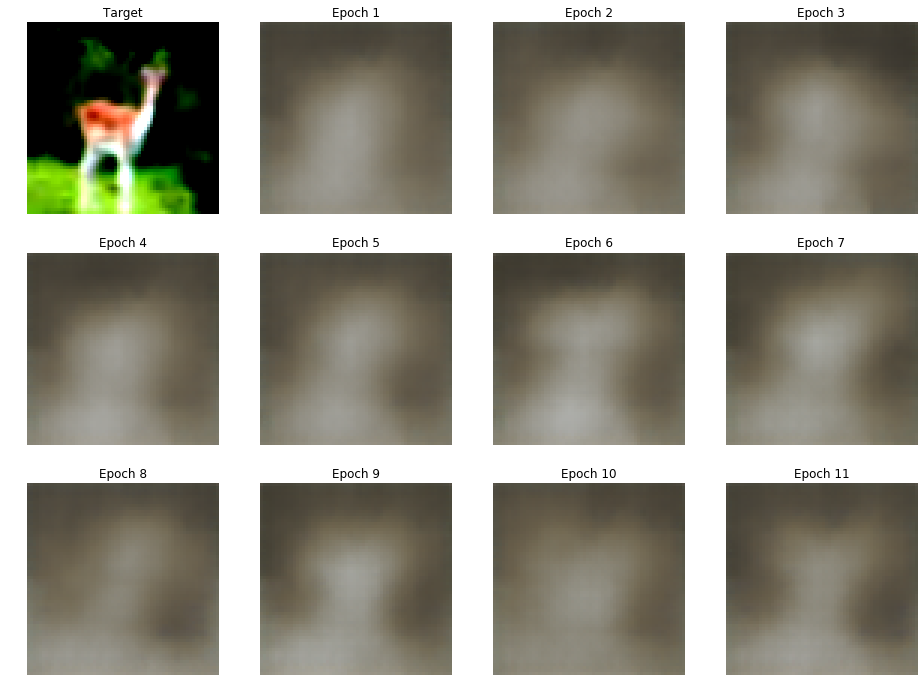

In [68]:
learn.unfreeze()
learn.fit_one_cycle(50,1e-3)

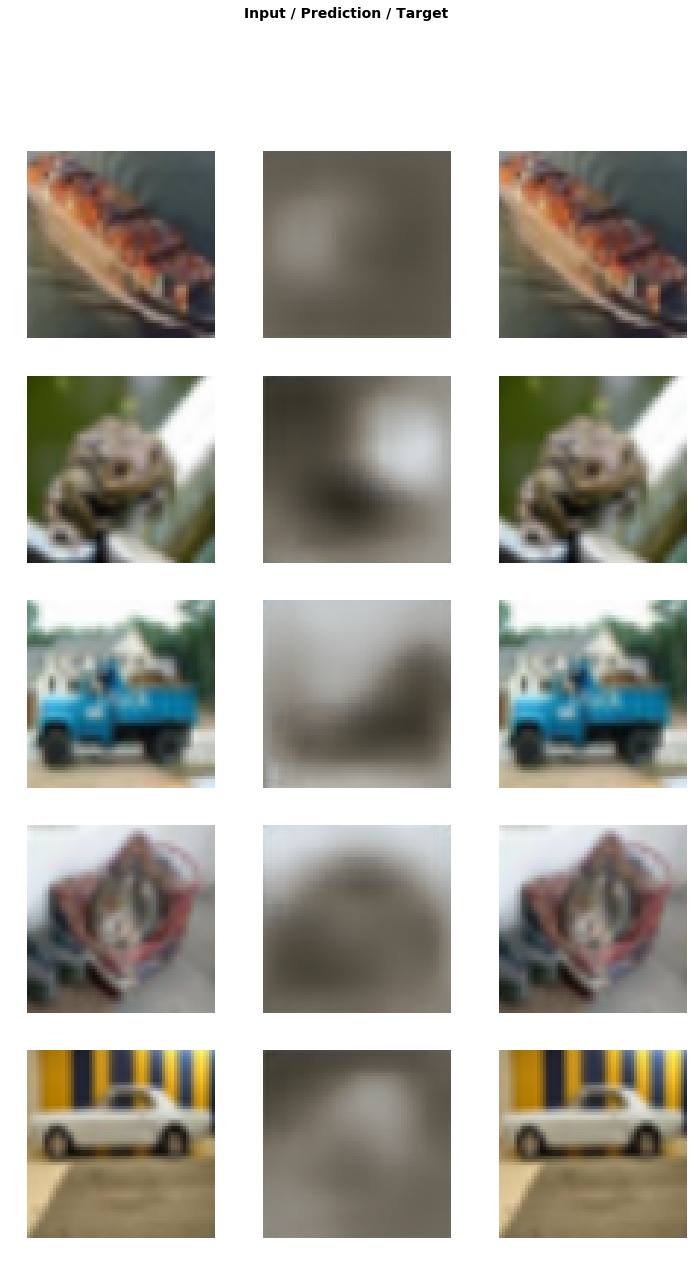

In [103]:
learn.show_results()

In [11]:
class SidekickAlexnetBase(nn.Module):
    def __init__(self,width=8,pretrained=True):
        super().__init__()
        
        self.hero = create_body(models.alexnet,pretrained=pretrained)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.features = nn.ModuleList(
            [nn.Sequential(conv2d(3, 8*width, ks=11, stride=4, padding=2,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(conv2d(8*width + 64, 24 * width, ks=5, padding=2,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(conv2d(24*width + 192, 48 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True)),
            nn.Sequential(conv2d(48*width + 384, 32 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True)),
            nn.Sequential(conv2d(32*width + 256, 32 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2))])

    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        x = self.features[0](x)
        for f, a in zip(self.features[1:],self.hooks.stored):
            x = f(torch.cat([x,a],dim=1))
            
        x = torch.cat([x,pt],dim=1)    
        return x

In [17]:
class SidekickAlexNet(nn.Module):
    def __init__(self, num_classes=1000,width=8,pretrained=True):
        super().__init__()
        self.sk = SidekickAlexnetBase(width,pretrained)
        self.classifier = create_head((32*width + 256)*2,num_classes)

    def forward(self, x):
        x = self.sk(x)
        x = self.classifier(x)
        return x


In [13]:
def logloss(preds,target):
    preds = torch.softmax(preds,dim=1)
    preds = preds.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    return torch.tensor(log_loss(target,preds))

In [63]:
learn = create_cnn(data,models.alexnet,metrics=[accuracy,logloss])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


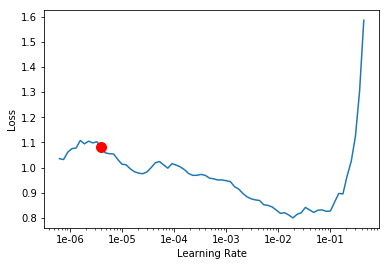

In [55]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.freeze()

In [65]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.619406,0.618720,0.687500,0.618720
2,0.558581,0.601943,0.693750,0.601943
3,0.561132,0.572954,0.781250,0.572954
4,0.580433,0.616092,0.765625,0.616092
5,0.531126,1.154402,0.746875,0.807176
6,0.504107,5.099136,0.793750,0.754481
7,0.489494,7.626073,0.800000,0.870637
8,0.470486,0.524166,0.784375,0.524166
9,0.453674,5.592858,0.796875,0.630209
10,0.449815,3.262070,0.790625,0.746528


In [66]:
learn.unfreeze()
learn.fit_one_cycle(20,1e-5)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.401628,8.721392,0.790625,0.921664
2,0.441153,1.320229,0.787500,0.803541
3,0.411897,0.669040,0.796875,0.561244
4,0.420835,1.900934,0.796875,0.620184
5,0.423765,5.637692,0.743750,0.903986
6,0.405368,1.930288,0.800000,0.653685
7,0.390942,0.424685,0.781250,0.424685
8,0.392852,1.146723,0.775000,0.724117
9,0.406112,0.973818,0.806250,0.807371
10,0.398754,0.423954,0.803125,0.423954


In [56]:
learnSK = Learner(data,SidekickAlexNet(data.train_ds.c,width=8),metrics=[accuracy,logloss])
learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])

In [57]:
learnSK.model(next(iter(data.train_dl))[0]).shape

torch.Size([16, 2])

In [58]:
learnSK.freeze_to(1)

In [59]:
learnSK.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.486228,0.403169,0.821875,0.403169
2,0.450465,0.707715,0.631250,0.707715
3,0.415396,0.452418,0.781250,0.452418
4,0.417829,1.458202,0.506250,1.458202
5,0.411181,1.235410,0.559375,1.235410
6,0.382128,0.841397,0.556250,0.841397
7,0.379635,1.718413,0.603125,1.718413
8,0.377921,0.621653,0.731250,0.621653
9,0.396330,0.542994,0.678125,0.542994
10,0.368237,0.423526,0.762500,0.423526


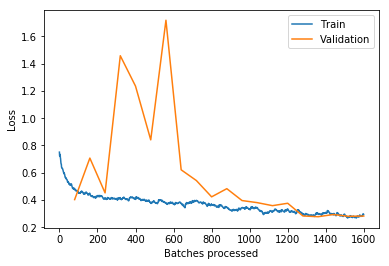

In [60]:
learnSK.recorder.plot_losses()

In [61]:
learnSK.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.300769,0.276884,0.871875,0.276884
2,0.286123,0.278006,0.890625,0.278006
3,0.297537,0.299606,0.856250,0.299606
4,0.285355,0.279791,0.881250,0.279791
5,0.289923,0.272996,0.875000,0.272996
6,0.284687,0.296406,0.859375,0.296405
7,0.269735,0.273452,0.890625,0.273452
8,0.271881,0.277104,0.881250,0.277104
9,0.268190,0.278516,0.893750,0.278516
10,0.264537,0.282992,0.884375,0.282992


In [ ]:
learnSK.save("sz128")

In [13]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [14]:
base_loss = F.l1_loss
vgg_m = models.vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\lordn/.torch\models\vgg16_bn-6c64b313.pth
100%|██████████████████████████████████████████████████████████████| 553507836/553507836 [00:25<00:00, 21869771.34it/s]


([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [15]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = fastai.callbacks.hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [16]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])